In [228]:
import numpy as np
from scipy.stats import beta
import pandas as pd
from matplotlib import pyplot as plt
from celluloid import Camera
import seaborn as sns
import inflect 


class Bandit:
    def __init__(self, true_probability):
        self.true_probability = true_probability
        self.alpha = 1
        self.beta = 1
        self.mean = 0.5
        
    def pull(self):
        return np.random.random() < self.true_probability

    def sample(self):
        return np.random.beta(self.alpha, self.beta)

    def update(self, reward):
        self.alpha += reward
        self.beta += (1 - reward)
        self.mean = self.alpha/(self.alpha + self.beta)
        
def Thompson(bandits, num_trials):
    rewards = np.zeros(num_trials)
    prob_dict = {i: [] for i in range(len(bandits))}
    action_list = []                                    
    for i in range(num_trials):
        # Thompson sampling
        j = np.argmax([b.sample() for b in bandits])
        action_list.append(j)
        # Pull the arm for the bandit with the largest sample
        reward = bandits[j].pull()

        # Update rewards log
        rewards[i] = reward

        # Update the distribution for the bandit whose arm we just pulled
        bandits[j].update(reward)
        [prob_dict[i].append(bandits[i].mean) for i in range(len(bandits))]
    return rewards, prob_dict, action_list

# Suppose we have 3 bandits with these true probabilities
true_probabilities = [0.53, 0.52, 0.5, 0.51, 0.49]



bandits = [Bandit(p) for p in true_probabilities]

# Run experiment
rewards, prob_dict , action_list = Thompson(bandits, num_trials=10000)

# Print the total reward
print("Total reward earned:", rewards.sum())
print("Overall win rate:", rewards.sum() / len(rewards))


Total reward earned: 5310.0
Overall win rate: 0.531


In [229]:
actions=pd.DataFrame(action_list, columns=['actions'])
actions.reset_index(inplace=True)
actions.rename(columns={'index':'event'}, inplace=True)

actions=pd.get_dummies(actions.actions).astype('int')
actions.cumsum()


df = pd.DataFrame()
for i in actions.columns:
    d = actions.iloc[:,i].cumsum()
    df = pd.concat([df, d], axis=1)


p = inflect.engine()
variants = [p.number_to_words(i+1) for i in df.columns]
df.columns = variants
df.reset_index(names='time_step', inplace=True)
df = pd.melt(df, id_vars=['time_step'])
df.columns=['time_step', 'variant', 'action_cnt']
df.variant = df.variant.str.capitalize()



In [230]:
variants = list(np.arange(1, len(true_probabilities)+1))





/var/folders/r2/7pvjqt_d343bmb7gz6x297mr0000gn/T/ipykernel_25446/2787166350.py:16: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  sns.barplot(x="action_cnt", y="variant", data=df.query('time_step == @i'),
/var/folders/r2/7pvjqt_d343bmb7gz6x297mr0000gn/T/ipykernel_25446/2787166350.py:16: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  sns.barplot(x="action_cnt", y="variant", data=df.query('time_step == @i'),
/var/folders/r2/7pvjqt_d343bmb7gz6x297mr0000gn/T/ipykernel_25446/2787166350.py:16: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  sns.barplot(x="action_cnt", y="variant", data=df.query('time_step == @i'),
/var/folders/r2/7pvjqt_d343bmb7gz6x297mr0000gn/T/ipykernel_25446/2787166350.py:16: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  sns.barplot(x="action_cnt", y="variant", data=df.query(

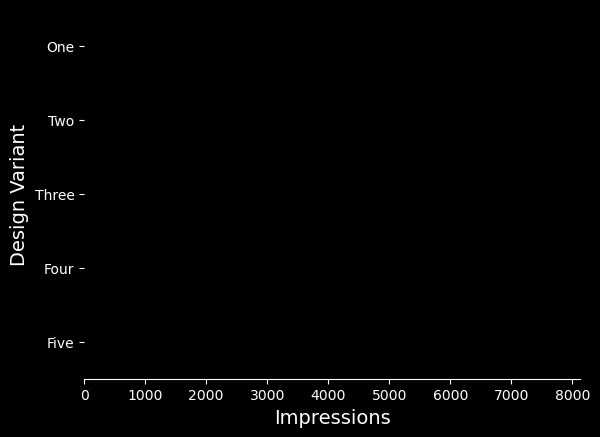

In [231]:
# Create an array with the colors you want to use

#UPDATE TO BE DYNAMIC
colors = ["#FF0B04", "#4374B3"]#, "#bd00ff"

# Set your custom color palette
sns.set_palette(sns.color_palette(colors))

fig, ax1 =plt.subplots()

step_size =100

camera = Camera(fig)
for i in range(df.time_step.max()):
    if i % step_size == 0:
        sns.barplot(x="action_cnt", y="variant", data=df.query('time_step == @i'),
                 ax=ax1, palette = sns.color_palette('bright'), hue = 'variant')


        ax1.set_ylabel('Design Variant', size=14)
        ax1.set_xlabel('Impressions', size=14)
        ax1.spines['top'].set_visible(False)
        ax1.spines['right'].set_visible(False)
        ax1.spines['left'].set_visible(False)
        ax1.text(0.7, 0.1, f'Total: {i:,.0f}', transform=ax1.transAxes, color ='white', size=16)
        #plt.title('Best variant is One', size=14)


        camera.snap()
animation = camera.animate()
animation.save('celluloid.gif', writer = 'imagemagick')


,time_step,variant,action_cnt
0,0,One,0
1,1,One,0
2,2,One,1
3,3,One,2
4,4,One,3
...,...,...,...
19995,9995,Two,3671
19996,9996,Two,3671
19997,9997,Two,3671
19998,9998,Two,3671


Text(0.4, 0.7, 'Correct Position')

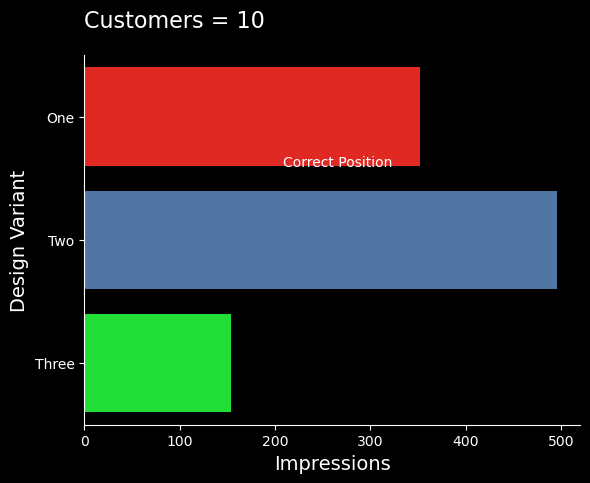

In [127]:
plt.style.use("dark_background")
fig, ax = plt.subplots()
sns.barplot(x="action_cnt", y="variant", data=df.query('time_step == 1000'),
                label="Total", ax=ax, palette = colors, hue = 'variant')

plt.ylabel('Design Variant', size=14)
plt.xlabel('Impressions', size=14)
plt.title("Customers = 10", size=16, loc='left', pad =20)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.text(0.4, 0.7, 'Correct Position', transform=ax.transAxes, color ='white')




In [44]:
bandits